# AAPL Options Data Analysis

## Fetching data 

Here I import relevant packages, and fetch AAPL call options data from "2023-01-01" to "2025-05-16", using free data pipeline offered by [market data](https://www.marketdata.app/)

I define a subscript at `scripts/fetch_options.py`. Running `python3 scripts/fetch_options.py` will download the options data into the `option_data` folder. The following cell first checks if the csv has already been downloaded, if not it will run `scripts/fetch_options.py` to download:

In [13]:
# load options
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path = "../option_data/options_AAPL.csv"

# Check if the file exists
if not os.path.exists(csv_path):
    print(f"{csv_path} not found. Fetching data...")
    subprocess.run(["python3", "../scripts/fetch_options.py"], check=True)
print("Loading options data from CSV...")
options = pd.read_csv(csv_path)
options.head()

Loading options data from CSV...


,optionSymbol,underlying,expiration,side,strike,firstTraded,dte,updated,bid,bidSize,...,volume,inTheMoney,intrinsicValue,extrinsicValue,underlyingPrice,iv,delta,gamma,theta,vega
0,AAPL250516C00095000,AAPL,1747425600,call,95.0,1744119000,3,1746820800,102.75,105,...,0,True,103.53,0.005,198.53,0.000,1.000,0.0,0.000,0.000
1,AAPL250516C00100000,AAPL,1747425600,call,100.0,1736260200,3,1746820800,97.95,105,...,100,True,98.53,0.045,198.53,0.500,1.000,0.0,-0.006,0.000
2,AAPL250516C00105000,AAPL,1747425600,call,105.0,1736260200,3,1746820800,92.75,105,...,4,True,93.53,0.095,198.53,1.758,0.997,0.0,-0.038,0.257
3,AAPL250516C00110000,AAPL,1747425600,call,110.0,1736260200,3,1746820800,87.45,105,...,37,True,88.53,0.080,198.53,0.000,1.000,0.0,0.000,0.000
4,AAPL250516C00115000,AAPL,1747425600,call,115.0,1736260200,3,1746820800,82.60,105,...,4,True,83.53,0.105,198.53,0.000,1.000,0.0,0.000,0.000


In [2]:
options.columns

Index(['optionSymbol', 'underlying', 'expiration', 'side', 'strike',
       'firstTraded', 'dte', 'updated', 'bid', 'bidSize', 'mid', 'ask',
       'askSize', 'last', 'openInterest', 'volume', 'inTheMoney',
       'intrinsicValue', 'extrinsicValue', 'underlyingPrice', 'iv', 'delta',
       'gamma', 'theta', 'vega'],
      dtype='object')

## Preprocessing

We turn date into `pd.datetime` format

In [3]:
if 'expiration' in options.columns:
    options['expiration_date'] = pd.to_datetime(options['expiration'], unit='s')
    options['first_traded_date'] = pd.to_datetime(options['firstTraded'], unit='s')
    options['last_updated_date'] = pd.to_datetime(options['updated'], unit='s')
    # remove expiration, firstTraded, and updated columns
    options = options.drop(columns=['expiration', 'firstTraded', 'updated'])

print("\nExpiration Date Range:")
print(f"Min: {options['expiration_date'].min()}, Max: {options['expiration_date'].max()}")

print("\nFirst Traded Date Range:")
print(f"Min: {options['first_traded_date'].min()}, Max: {options['first_traded_date'].max()}")



Expiration Date Range:
Min: 2025-05-16 20:00:00, Max: 2025-05-16 20:00:00

First Traded Date Range:
Min: 2025-01-06 14:30:00, Max: 2025-05-01 13:30:00


In [4]:
options = options.drop(columns=['optionSymbol'])
options.head()

,underlying,side,strike,dte,bid,bidSize,mid,ask,askSize,last,...,extrinsicValue,underlyingPrice,iv,delta,gamma,theta,vega,expiration_date,first_traded_date,last_updated_date
0,AAPL,call,95.0,3,102.75,105,103.525,104.30,105,104.25,...,0.005,198.53,0.000,1.000,0.0,0.000,0.000,2025-05-16 20:00:00,2025-04-08 13:30:00,2025-05-09 20:00:00
1,AAPL,call,100.0,3,97.95,105,98.575,99.20,105,97.95,...,0.045,198.53,0.500,1.000,0.0,-0.006,0.000,2025-05-16 20:00:00,2025-01-07 14:30:00,2025-05-09 20:00:00
2,AAPL,call,105.0,3,92.75,105,93.625,94.50,105,93.48,...,0.095,198.53,1.758,0.997,0.0,-0.038,0.257,2025-05-16 20:00:00,2025-01-07 14:30:00,2025-05-09 20:00:00
3,AAPL,call,110.0,3,87.45,105,88.450,89.45,105,87.95,...,0.080,198.53,0.000,1.000,0.0,0.000,0.000,2025-05-16 20:00:00,2025-01-07 14:30:00,2025-05-09 20:00:00
4,AAPL,call,115.0,3,82.60,105,83.425,84.25,105,83.55,...,0.105,198.53,0.000,1.000,0.0,0.000,0.000,2025-05-16 20:00:00,2025-01-07 14:30:00,2025-05-09 20:00:00


Since we have a lot of options, we will only study short-dated options data today at 2025-05-13, expiring three days later on 2025-05-16:

In [5]:
filtered_options = options[
    (options['dte'] == 3) &
    (options['expiration_date'] == '2025-05-16 20:00:00')
]
filtered_options

,underlying,side,strike,dte,bid,bidSize,mid,ask,askSize,last,...,extrinsicValue,underlyingPrice,iv,delta,gamma,theta,vega,expiration_date,first_traded_date,last_updated_date
0,AAPL,call,95.0,3,102.75,105,103.525,104.30,105,104.25,...,0.005,198.53,0.000,1.000,0.000,0.000,0.000,2025-05-16 20:00:00,2025-04-08 13:30:00,2025-05-09 20:00:00
1,AAPL,call,100.0,3,97.95,105,98.575,99.20,105,97.95,...,0.045,198.53,0.500,1.000,0.000,-0.006,0.000,2025-05-16 20:00:00,2025-01-07 14:30:00,2025-05-09 20:00:00
2,AAPL,call,105.0,3,92.75,105,93.625,94.50,105,93.48,...,0.095,198.53,1.758,0.997,0.000,-0.038,0.257,2025-05-16 20:00:00,2025-01-07 14:30:00,2025-05-09 20:00:00
3,AAPL,call,110.0,3,87.45,105,88.450,89.45,105,87.95,...,0.080,198.53,0.000,1.000,0.000,0.000,0.000,2025-05-16 20:00:00,2025-01-07 14:30:00,2025-05-09 20:00:00
4,AAPL,call,115.0,3,82.60,105,83.425,84.25,105,83.55,...,0.105,198.53,0.000,1.000,0.000,0.000,0.000,2025-05-16 20:00:00,2025-01-07 14:30:00,2025-05-09 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,AAPL,put,300.0,3,101.30,105,101.800,102.30,105,76.84,...,0.330,198.53,1.501,-0.970,0.002,-0.184,1.871,2025-05-16 20:00:00,2025-01-06 14:30:00,2025-05-09 20:00:00
114,AAPL,put,305.0,3,105.90,105,106.725,107.55,105,0.00,...,0.255,198.53,1.505,-0.975,0.001,-0.158,1.625,2025-05-16 20:00:00,2025-01-06 14:30:00,2025-05-09 20:00:00
115,AAPL,put,310.0,3,111.15,100,111.650,112.15,100,88.85,...,0.180,198.53,1.505,-0.979,0.001,-0.132,1.391,2025-05-16 20:00:00,2025-01-06 14:30:00,2025-05-09 20:00:00
116,AAPL,put,315.0,3,116.25,100,116.725,117.20,100,82.45,...,0.255,198.53,1.599,-0.976,0.001,-0.162,1.570,2025-05-16 20:00:00,2025-01-06 14:30:00,2025-05-09 20:00:00


## Data Analysis

Abbreviations: IV (Implied Vol), ATM(At-the-money, option has strike = stock), OTM(out-of-the-money), ITM(In-the-money),
B-S (Black-Scholes)

We first plot the price of call and put options with respect to different strikes:

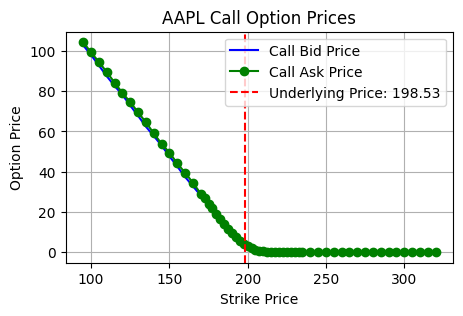

In [14]:
call_options = filtered_options[filtered_options['side'] == 'call']
put_options = filtered_options[filtered_options['side'] == 'put']
underlying_price = filtered_options['underlyingPrice'].iloc[0]

plt.figure(figsize=(5, 3))
plt.plot(call_options['strike'], call_options['bid'], label='Call Bid Price', color='b')
plt.plot(call_options['strike'], call_options['ask'], label='Call Ask Price', marker='o', color='g')

# Add a vertical line at the underlying price
plt.axvline(x=underlying_price, color='r', linestyle='--', label=f'Underlying Price: {underlying_price}')

# Add labels, legend, and title
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('AAPL Call Option Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


We have payoffs for call $C(K) = (S-K)^+$, where $S$ is the stock price at expiry, and put $P(K) = (K-S)^+$

Clearly as strike increase, the call payoff decreases, so it gets cheaper. We should expect a montonically decreasing function w.r.t. strike for the call, as observed. Similarly the put having $P(K) = (K-S)^+$ should have monotonically increasing w.r.t. strike:

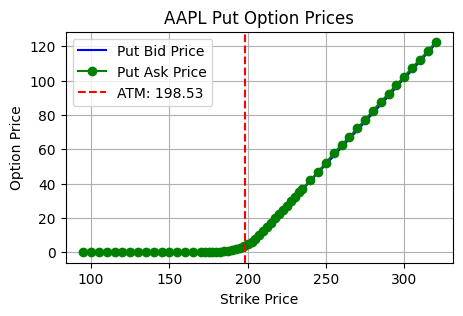

In [15]:
plt.figure(figsize=(5, 3))
plt.plot(put_options['strike'], put_options['bid'], label='Put Bid Price', color='b')
plt.plot(put_options['strike'], put_options['ask'], label='Put Ask Price', marker='o', color='g')
plt.axvline(x=underlying_price, color='r', linestyle='--', label=f'ATM: {underlying_price}')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('AAPL Put Option Prices')
plt.legend()
plt.grid(True)



### Implied Vol

We will first study the implied volatility (IV), given in the options data. IV is the volatility input into the Black-Scholes model for options pricing. It is a property of the option, so the more expensive an option is, the higher IV it will imply. Under BS framework, a stock should have constant volatility, but in fact due to inconsistent market pricing, stocks would have different IV at different strikes, known as the 'volatility smile'.

We quote the Black-Scholes formula for a European call option:

$$
C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)
$$

where

$$
d_1 = \frac{\ln(S_0 / K) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}
$$

and IV is given by $\sigma_{\text{impl}}$ such that

$$
C_{\text{market}} = C_{\text{Black-Scholes}}(\sigma_{\text{impl}})
$$

IV needs to be solved numerically, using Newton's method or bisection, etc.

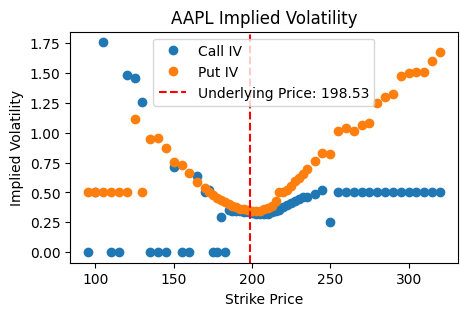

In [ ]:
# plot IV
plt.figure(figsize=(5, 3))
# plt.plot(filtered_options['strike'], filtered_options['iv'], 'o')
plt.plot(call_options['strike'], call_options['iv'], 'o', label='Call IV')
plt.plot(put_options['strike'], put_options['iv'], 'o', label='Put IV')

# add underlying price
plt.axvline(x=underlying_price, color='r', linestyle='--', label=f'Underlying Price: {underlying_price}')
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("AAPL Implied Volatility")
plt.legend()
plt.show()


Note the convention is to use the IV of OTM calls and OTM puts, so we replot here:

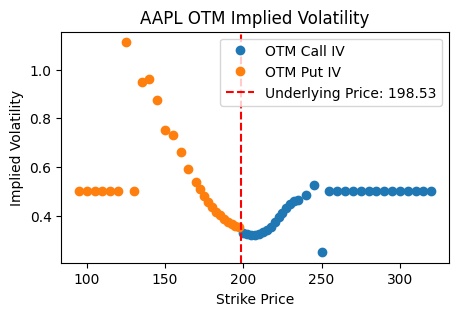

In [12]:
# plot OTM call and put IV
plt.figure(figsize=(5, 3))

# filter OTM calls and puts
otm_calls = call_options[call_options['strike'] > underlying_price]
otm_puts = put_options[put_options['strike'] < underlying_price]

# plot IV for OTM calls and puts
plt.plot(otm_calls['strike'], otm_calls['iv'], 'o', label='OTM Call IV')
plt.plot(otm_puts['strike'], otm_puts['iv'], 'o', label='OTM Put IV')

# add underlying price
plt.axvline(x=underlying_price, color='r', linestyle='--', label=f'Underlying Price: {underlying_price}')
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("AAPL OTM Implied Volatility")
plt.legend()
plt.show()


This is somewhat a 'smile' structure, as we can see IV is lowest when options have strike equal to current AAPL stock price. IV is higher for OTM calls (strike > underlying), as people buy OTM calls for speculation. IV is also higher for OTM puts (strike < underlying), as institutions which have long positions in stocks often buy OTM puts for hedging / protection.

### Delta

Delta is the most important greek with respect to an option. It is given by $dV/dS$, or how sensitive the option is to movement of underlying. Under B-S framework, delta of call option is given by $\phi(d_1)$

For shorted-dated option, ATM call and put should roughly have $ \Delta = \pm 0.5 $. This is because we have for ATM call ($S = K$), as $ T \to 0$:

$$
d_{1,2} = \frac{\left(r \pm \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}}
\to \frac{\sigma \sqrt{T}}{2} \to 0
$$

$$
\phi(d_1), \phi(d_2) \to 0.5
$$

As strike increases, OTM call options should have delta convering to 0, while as strike decreases, ITM call delta converge to 1.  
We verify that by plotting call and put options for AAPL with respect to strike price:

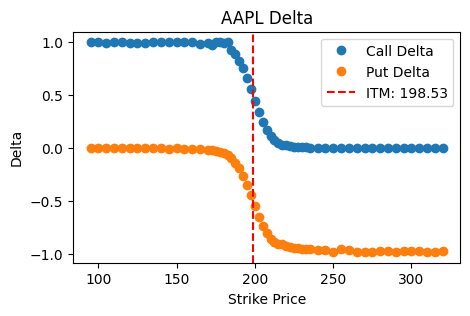

In [8]:
# plot delta
plt.figure(figsize=(5, 3))
plt.plot(call_options['strike'], call_options['delta'], 'o', label='Call Delta')
plt.plot(put_options['strike'], put_options['delta'], 'o', label='Put Delta')

# add underlying price
underlying_price = filtered_options['underlyingPrice'].iloc[0]
plt.axvline(x=underlying_price, color='r', linestyle='--', label=f'ITM: {underlying_price}')
plt.xlabel("Strike Price")
plt.ylabel("Delta")
plt.title("AAPL Delta")
plt.legend()
plt.show()